## $\kappa$-velo scaling on simulation

In this notebook we will apply our $\kappa$-velo method to a simulation. More specifically, in this notebook we are interested in the scaling of the parameters $\alpha$, $\beta$ and $\gamma$, which is one of the steps in the $\kappa$-velo workflow. You can use this notebook to reproduce figures 2B-E and S2.

In [1]:
### load libraries

# general libraries
import pandas as pd

# single cell libraries
import scvelo as scv

# plotting libraries
import matplotlib.pyplot as plt

# dimension reduction libraries
from sklearn.decomposition import PCA #for generating a PCA embedding

# import our own functions
from functions import *
from visualisation import *

In [2]:
### set scvelo settings
scv.settings.verbosity = 0 

### Generate simulation data

Here, we generate the simulation data that we will be using to test our $\kappa$-velo method. The simulation is create using the build in function from scVelo: `scvelo.datasets.simulation`. Our simulation contains 200 genes and 5000 cells. The parameters $\alpha$, $\beta$ and $\gamma$ are sampled from a multivariate log-normal distribution and scaled by a scaling factor $\kappa$ between 1 and 10.

In [3]:
### set seed
np.random.seed(2)

In [4]:
### set variables for simulation
n_vars, n_obs, t_max, noise_level = 20, 5000, 30, 1
switches = np.random.uniform(.1, .5, size=n_vars)

In [5]:
### set parameters
mu = np.array([np.log(5), np.log(.3), np.log(.15)])
R = np.array([[1, .2, .2],
              [.2, 1, .2],
              [.2, .2, 1]])
C = np.array([.2, .2, .2])[:, None]
cov = C.dot(C.T) * R

kappa = np.arange(1, 15, (15-1)/n_vars)

alpha, beta, gamma = np.exp(np.random.multivariate_normal(mu, cov, size=n_vars).T ) 

In [6]:
### set different scaling factors (kappa)
kappa = np.arange(1, 15, (15-1)/n_vars)

In [7]:
### generate dataset; fixed alpha, beta & gamma, only change kappa 
adata = scv.datasets.simulation(n_obs=n_obs, 
                                t_max=t_max, 
                                n_vars=n_vars, 
                                noise_level=noise_level, 
                                alpha=alpha*kappa, 
                                beta=beta*kappa, 
                                gamma=gamma*kappa, 
                                switches=switches/kappa)

### Recover dynamics and scaling factors ($\kappa$)

Here, we will calculate the velocities per cell for each gene. First, we recover the dynamics using function `scvelo.tl.recover_dynamics`. Afterwards, we use the $\kappa$-velo function `get_intervals` to fit a kappa to each gene using all cells assigned to downregulation (for that gene). In case a NaN is retrieved (because there are not enough cells in downregulation), we run the function `get_intervals` again, but this time on all cells in the upregulation.

In [ ]:
### recover scvelo dynamics
scv.tl.recover_dynamics(adata, adata.var_names, use_raw=True, fit_connected_states=False, t_max=20)

  0%|          | 0/20 [00:00<?, ?gene/s]

In [9]:
### get kappas
fitted_kappas = np.array([np.mean(get_intervals(adata, i, mode="u", reg="down", use_raw=True)) for i in adata.var_names])
fitted_kappas[np.isnan(fitted_kappas)]=np.array([get_intervals(adata, i, mode="u", reg="up", use_raw=True)[0] for i in np.where(np.isnan(fitted_kappas))[0]])

Here, we use a scatter plot to compare our fitted kappa's to the true kappa's. This figure is equivalent to Figure 2C in our main paper.

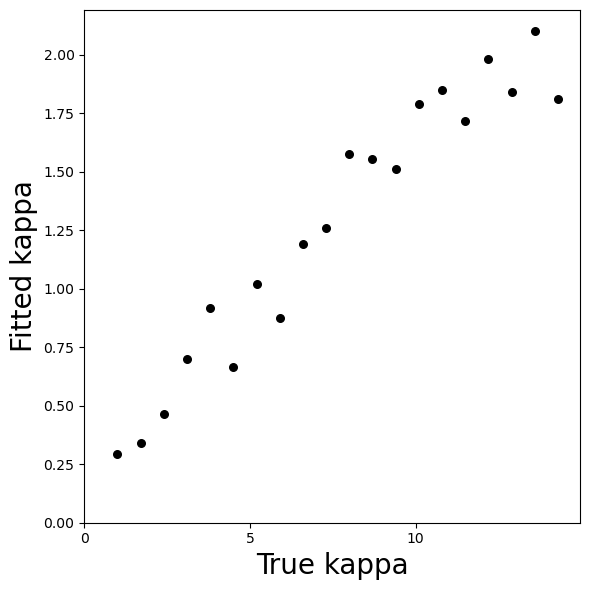

In [13]:
### plot fitted kappas vs true kappas
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.scatter(kappa, fitted_kappas*adata.var["fit_beta"] * 100, s=30, c="black")
plt.xlabel("True kappa", size=20), plt.ylabel("Fitted kappa", size=20)
plt.xlim(0), plt.ylim(0)
ax.set_xticks([0, 5, 10])
plt.tight_layout()

# save figure
#save_path = "../figures/Fig3C_recovered_kappas.png"
#plt.savefig(save_path, dpi=400, transparent=True)

plt.show()

### Calculate velocities

Here, we use the calculate velocities in three different ways. 
1. true velocities (`v_true`): velocities calculated using the ground truth parameters
2. scVelo velocities (`v_scvelo`): velocities calculated using the parameters recovered by scVelo
3. scaled velocities (`v_scaled`): velocities calculated using the $\kappa$-scaled parameters

Note: the velocities are L2 normalised to make them comparable.

In [31]:
### calculate ground truth velocities
true_data = adata.copy()
get_velocity(true_data, key="true", normalise="L2")
v_true = true_data.layers["velocity"]

In [33]:
### calculate scvelo velocities 
scv.pp.neighbors(adata)
scv.tl.velocity(adata, use_raw=True)
v_scvelo = sk.preprocessing.normalize(adata.layers["velocity"], norm='l2')

In [34]:
### calculate scaled velocities
scaled_data = adata.copy()
scaled_data.var["fit_beta"] *= fitted_kappas
scaled_data.var["fit_alpha"] *= fitted_kappas
scaled_data.var["fit_gamma"] *= fitted_kappas
get_velocity(scaled_data, use_raw=True, normalise="L2")
v_scaled = scaled_data.layers["velocity"]

Here, we use a scatter plot to compare the velocities estimated by scVelo and $\kappa$-velo to the true velocities. Each dot represents the velocity of one gene in one cell. This figure corresponds to Figure 2D in our paper.

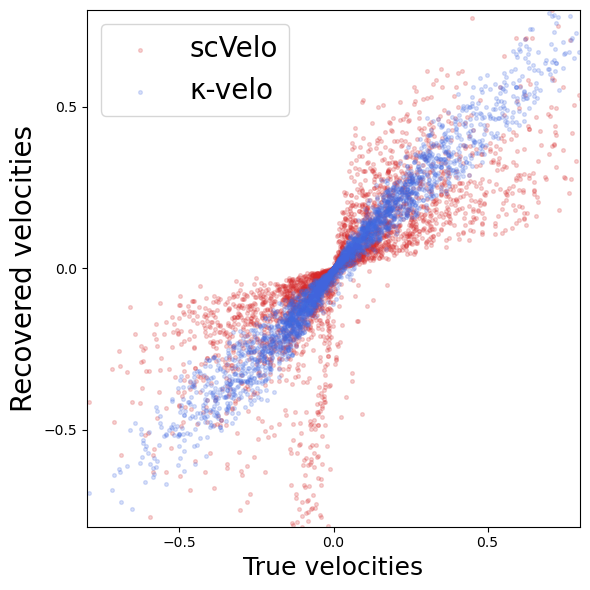

In [35]:
### plot figuring comparing scVelo and kappa-velo to ground truth
fig, ax = plt.subplots(1, 1, figsize=(6, 6), frameon=False)

kwargs = {"alpha":.2, "s":7}
idx = np.arange(0, n_vars, 1)
cells = np.arange(0, n_obs, 25)
xlim = (np.min(v_true), np.max(v_true))

# for all cell over all genes
ax.scatter(v_true[:,idx][cells], v_scvelo[:,idx][cells], 
           label="scVelo", color="tab:red", **kwargs)
ax.scatter(v_true[:,idx][cells], v_scaled[:,idx][cells], 
           label="κ-velo", color="royalblue", **kwargs)
ax.set_xlabel("True velocities", size=18), ax.set_ylabel("Recovered velocities", size=20)

l = .8
ax.set_xlim((-l,l)), ax.set_ylim((-l, l))

ax.legend(fontsize=20)
ax.set_xticks([-.5, 0, .5]), ax.set_yticks([-.5, 0, .5])
plt.tight_layout()

# save figure
#save_path = "../figures/Fig3D_velocities-scvelo-vs-scaled.png"
#plt.savefig(save_path, dpi=400, transparent=True)

plt.show()

### Projection onto PCA space

Here, we project the velocities, as calculated by scVelo and $\kappa$-velo onto a PCA embedding and compare it with the true velocities. We compare the velocities both in terms of change in vector direction and change in vector length. To compare the vector direction, we use our function `change`, which uses cosine similarity to determine the difference in direction between two vectors. To compare the vector length, we use the same function `change`, but this time with metric "length", which compares the length of the vector using the difference in vector norm.

In [18]:
### generate PCA embedding using spliced counts
pca = PCA(n_components=2, copy=True)
pc = pca.fit(adata.X)
data = pc.transform(adata.X)

In [19]:
### calculate projection of velocities (true, scVelo and scaled) onto PCA
zero = pca.transform(np.zeros((1,n_vars)))

v_t = pca.transform(v_true)-zero
v_0 = pca.transform(v_scvelo)-zero
v_1 = pca.transform(v_scaled)-zero

In [24]:
%load_ext autoreload
%autoreload 2

from visualisation import *

In [25]:
### calculate change in direction
a0, a1 = vector_d(v_t, v_0, metric="cosine"), vector_d(v_t, v_1, metric="cosine")

In [26]:
v_t.shape

(5000, 2)

In [27]:
### calculate change in angle
d0, d1 = vector_d(v_t, v_0, metric="norm_diff"), vector_d(v_t, v_1, metric="norm_diff")

Here, we plot the simulation in a PCA embedding. The grey velocities represent the true velocities. The red and blue velocities represent the scVelo-calculate and kappa-scaled velocities respectively.

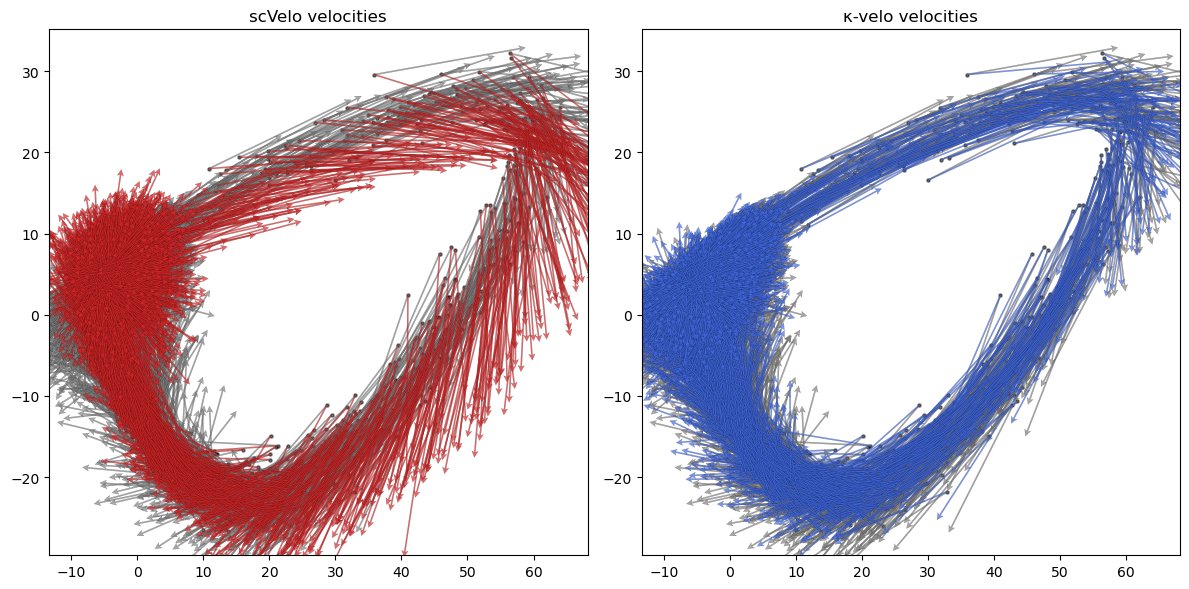

In [22]:
### plot velocities in PCA
fig, axs = plt.subplots(1,2, figsize=(12, 6), frameon=False)

axs[0].scatter(data[:,0], data[:,1], s=5, color="black", alpha=.5)
axs[1].scatter(data[:,0], data[:,1], s=5, color="black", alpha=.5)

quiver_kwargs = {"scale": .04, "angles": "xy", "scale_units": "xy",
                 "edgecolors": "k", "linewidth": 0.1, "headwidth": 5, "headaxislength": 4, "alpha":.7}

axs[0].quiver(data[:,0], data[:,1], v_t[:,0], v_t[:,1], color="grey", **quiver_kwargs)
axs[1].quiver(data[:,0], data[:,1], v_t[:,0], v_t[:,1], color="grey", **quiver_kwargs)
axs[0].quiver(data[:,0], data[:,1], v_0[:,0], v_0[:,1], color="tab:red", **quiver_kwargs)
axs[1].quiver(data[:,0], data[:,1], v_1[:,0], v_1[:,1], color="royalblue", **quiver_kwargs)

axs[0].set_title("scVelo velocities")
axs[1].set_title("κ-velo velocities")

plt.tight_layout()
plt.show()

Here, we compare the vectors in the PCA embedding in terms of size and angle.

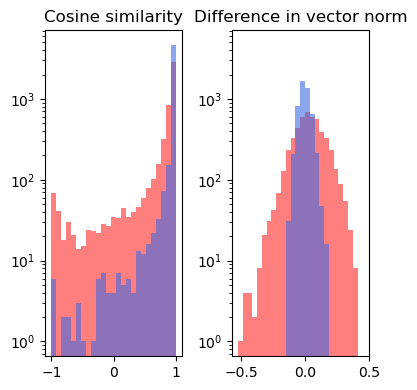

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(4,4), frameon=False, gridspec_kw={'width_ratios': [ 1, 1]})

axs[0].set_yscale('log') 

kwargs = {"alpha":0.5, "density":False, "bins":25}

_, bins, _ = axs[0].hist(a0, **kwargs, label="scVelo", color="r")
axs[0].hist(a1, bins=bins, alpha = .6, color="royalblue", label=["K-SV"])
axs[0].set_xticks([-1, 0, 1])

axs[0].set_yscale('log') 
axs[0].set_title("Cosine similarity")

_, bins, _ = axs[1].hist(d0, **kwargs, label="scVelo", color="r")
axs[1].hist(d1, bins=bins, alpha = .6, color="royalblue", label=["K-SV"])
axs[1].set_title("Difference in vector norm")
axs[1].set_yscale('log') 
axs[1].sharey(axs[0])
axs[1].set_xticks([-.5, 0, .5])

ax.grid(False)
ax.legend(fontsize=20)
plt.tight_layout()

# save figure
#save_path = "../figures/Fig3E_length_and_direction_compared.png"
#plt.savefig(save_path, dpi=400, transparent=True)

plt.show()

Here, we plot all three figures (Figure 2C-E) in the same figure. 

In [ ]:
### plot all three figures together
fig, axs = plt.subplots(1, 4, figsize=(12,4), frameon=False, gridspec_kw={'width_ratios': [2, 2, 1, 1]})

# plot recovered kappas
axs[0].scatter(kappa, fitted_kappas*adata.var["fit_beta"] * 300, 
            s=10, c="black")
axs[0].set_xticks([0, 5, 10, 15])
axs[0].set_yticks([0, 5, 10])

# plot velocities comparison 
kwargs = {"alpha":.2, "s":7}
idx = np.arange(0, n_vars, 1)
cells = np.arange(0, n_obs, 25)
axs[1].scatter(v_true[:,idx][cells], v_scvelo[:,idx][cells], color="tab:red", **kwargs)
axs[1].scatter(v_true[:,idx][cells], v_scaled[:,idx][cells], color="royalblue", **kwargs)
l = .5
axs[1].set_xlim((-l,l)), axs[1].set_ylim((-l, l))
axs[1].set_xticks([-.5, 0, .5]), axs[1].set_yticks([-.5, 0, .5])

# plot direction comparison
axs[2].set_yscale('log') 
kwargs = {"alpha":0.5, "density":False, "bins":25}
_, bins, _ = axs[2].hist(a0, **kwargs, label="scVelo", color="r")
axs[2].hist(a1, bins=bins, alpha = .6, color="royalblue", label=["K-SV"])
axs[2].set_xticks([-1, 0, 1])
axs[2].set_yscale('log') 

# plot size comparison
_, bins, _ = axs[3].hist(d0, **kwargs, label="scVelo", color="r")
axs[3].hist(d1, bins=bins, alpha = .6, color="royalblue", label=["K-SV"])
axs[3].set_yscale('log') 
axs[3].sharey(axs[2])
axs[3].set_xticks([-.5, 0, .5])

ax.grid(False)
ax.legend(fontsize=20)
plt.tight_layout()

# save figure
save_path = "../figures/Fig3C-E_kappa_on_simulation.png"
plt.savefig(save_path, dpi=400, transparent=True)

plt.show()

### Supplementary figures: parallelogram approach
To give you some insight on how $\kappa$-velo calculate scaling factor $\kappa$ for each gene, we zoom in on the application of the parallelogram approach on two genes a similar simulation. To get a better understanding of the approach, we highly recommend you to read Supplementary Note 1 in our manuscript. Below, you will find for both genes the u-s phase portrait and a scatter plot plotting $d(i,j)$ and $f(i,j)$, with a parellologram fitted around the points. The slope of the left border of the parellogram is used as an estimate for $\kappa$.

In [ ]:
### define kwargs & functions 
ptkwargs = {"s":3, "color":"grey", "alpha":.8}
lkwargs = dict(bounds=[(0.1, None)], x0=np.array([.1]), options={"maxiter": 2000, 'disp': True}, tol=1e-8, method="COBYLA")

def line(a, *args):
    x, y = args[0], args[1]
    x, y = x[x > .1], y[x > .1]
    return np.sum(np.sqrt(((a*x)-y)**2))

In [ ]:
### create new simulation 
np.random.seed(2)

n_vars, n_obs, t_max, noise_level = 2, 3000, 20, [0.8]

kappa = np.array([.5, 5])
alpha, beta, gamma, switches = 5*kappa, .3*kappa, .15*kappa, [.8, .8]
adata = scv.datasets.simulation(n_obs=n_obs, t_max=t_max, n_vars=n_vars, noise_level=noise_level, alpha=alpha, beta=beta, gamma=gamma, switches=switches)

scv.tl.recover_dynamics(adata, use_raw=True, max_iter=1000)

In [ ]:
### plot parallelogram approach for gene 1
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

j = "0"
alpha, beta, gamma, ut, st, _, _, _, _, up_reg, down_reg = get_pars(adata, j, use_raw=True)

# plot almond
scv.pl.scatter(adata,j, ax=ax[0], show=False, use_raw=True)
ax[0].set_title("Gene 1", size=15)

# get density kappa
alpha, beta, gamma, ut, st, _, _, _, _, up_reg, _ = get_pars(adata, j, use_raw=True)
t_dist, f = get_f_and_delta_t(ut, st, alpha, beta, _, up_reg, "up")
a = op.minimize(line, args=(t_dist / np.max(t_dist), f / np.max(f)), **lkwargs).x

# plot density kappa
ax[1].scatter(t_dist, f,  **ptkwargs)
ax[1].set_xlabel("d(i, j)"), ax[1].set_ylabel("f(i, j)")
ax[1].plot(np.array([0, a]) * np.max(t_dist), np.array([0, 1]) * np.max(f), color="red")

# make plot less crowded
for ax_ in ax:
    ax_.set_xlim(0), ax_.set_ylim(0)
    ax_.spines['right'].set_visible(False)
    ax_.spines['top'].set_visible(False)

plt.tight_layout()

# save figure
save_path = "../figures/FigS2A_density-parallelogram.pdf"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

In [ ]:
### print recovered kappa for gene 1
print(((1 * np.max(f)) / (a * np.max(t_dist)))*beta *100)

In [ ]:
### plot parallelogram approach for gene 2
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

j = "1"
alpha, beta, gamma, ut, st, _, _, _, _, up_reg, down_reg = get_pars(adata, j, use_raw=True)

# plot almond
scv.pl.scatter(adata,j, ax=ax[0], show=False, use_raw=True)
ax[0].set_title("Gene 2", size=15)

# plot density kappa
t_dist, f = get_f_and_delta_t(ut, st, alpha, beta, _, up_reg, "up")

kwargs = dict(bounds=[(0.1, None), (0.1, None), (0.1, None), (0.01, None)], x0=np.array([.1, 1, 1, .1]),
              options={"maxiter": 2000, 'disp': True}, tol=1e-8, method="COBYLA")
mn = op.minimize(cost_parallelogram, args=(t_dist / np.max(t_dist), f / np.max(f)), **kwargs)
a, b, c, d = mn.x

ax[1].scatter(t_dist, f, **ptkwargs)
ax[1].set_xlabel("d(i, j)"), ax[1].set_ylabel("f(i, j)")

# recovered kappa line
ax[1].plot(np.array([0, a]) * np.max(t_dist), np.array([0, b]) * np.max(f), color="red")

# rest of parallelogram
ax[1].plot(np.array([a, (a + c), c, 0]) * np.max(t_dist), np.array([b, (b + d), d, 0]) * np.max(f), color="orange")

for ax_ in ax:
    ax_.set_xlim(0), ax_.set_ylim(0)
    ax_.spines['right'].set_visible(False)
    ax_.spines['top'].set_visible(False)

plt.tight_layout()

# save figure
save_path = "../figures/FigS2B_density-parallelogram.pdf"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

In [ ]:
### print recovered kappa for gene 2
print(((b * np.max(f)) / (a * np.max(t_dist)))*beta *100)